In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from pyDOE import lhs  # Latin Hypercube Sampling for colocation points
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from scipy.stats import qmc
# Set default data type for tensors to float32
torch.set_default_dtype(torch.float)
dtype = torch.float

# Set random seeds for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# Define the physics-informed neural network (PINN) class
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        
        # Initialize layers list
        layers = []
        current_dim = input_dim

        # Build hidden layers with Xavier initialization
        for _ in range(num_layers):
            linear_layer = nn.Linear(current_dim, hidden_dim)
            nn.init.xavier_normal_(linear_layer.weight)
            layers.append(linear_layer)
            layers.append(nn.Tanh())
            current_dim = hidden_dim
        
        # Add output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        # Create the sequential model
        self.model = nn.Sequential(*layers)

    # Define forward pass through the network
    def forward(self, x):
        return self.model(x)
def solution_plot(u_pred, usol, x, t, X, T, X_u_train, u_train):
    
    fig = plt.figure(figsize=(9, 9))  # Adjust the figure size
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
    fig.subplots_adjust(hspace=0.4)  # Add more space between subplots

    # Plot u(x, t)
    ax = plt.subplot(gs[0])
    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                  extent=[T.min(), T.max(), X.min(), X.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', 
            label='Data (%d points)' % u_train.shape[0], 
            markersize=4, clip_on=False)
    
    for time_step in [25, 50, 75]:
        ax.plot(t[time_step] * np.ones((2, 1)), np.linspace(x.min(), x.max(), 2), 
                'w-', linewidth=1)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='upper right')
    ax.set_title('$u(x,t)$ - PINN solution', fontsize=12)

    # Plot error
    ax = plt.subplot(gs[1])
    error = np.abs(usol - u_pred)
    h = ax.imshow(error, interpolation='nearest', cmap='rainbow', 
                  extent=[T.min(), T.max(), X.min(), X.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', 
            label='Data (%d points)' % u_train.shape[0], 
            markersize=4, clip_on=False)
    
    for time_step in [25, 50, 75]:
        ax.plot(t[time_step] * np.ones((2, 1)), np.linspace(x.min(), x.max(), 2), 
                'w-', linewidth=1)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='best')
    ax.set_title('Error', fontsize=12)

    # u(x,t) slices
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2], wspace=0.5)
    
    time_steps = [25, 50, 75]
    titles = ['$t = 0.25s$', '$t = 0.50s$', '$t = 0.75s$']
    
    for i, time_step in enumerate(time_steps):
        ax = plt.subplot(gs2[0, i])
        ax.plot(x, usol.T[time_step, :], 'b-', linewidth=2, label='Exact')       
        ax.plot(x, u_pred.T[time_step, :], 'r--', linewidth=2, label='Prediction')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(x,t)$')    
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_title(titles[i], fontsize=10)
        ax.axis('square')

        if i == 1:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)

    plt.show()

In [2]:
# TODO: Instantiate the PINN model
pinn_model = PINN(
    input_dim=2,  # 2D input (x, t)
    hidden_dim=32,  # Hidden layer size
    output_dim=1,  # Output (u)
    num_layers=3  # Number of hidden layers
)

# Display the neural network architecture
print(pinn_model)


# Load numerical solution data from the file
data = scipy.io.loadmat('Data/burgers_shock_mu_01_pi.mat')
x = data['x']  # Spatial grid points (256 points between -1 and 1)
t = data['t']  # Time grid points (100 points between 0 and 1)
usol = data['usol']  # Solution matrix of shape (256, 100)

# Create a meshgrid from x and t arrays
X, T = np.meshgrid(x, t)

# Define the domain bounds
lower_bound = np.array([X.min(), T.min()])  # [x_min, t_min] = [-1, 0]
upper_bound = np.array([X.max(), T.max()])  # [x_max, t_max] = [1, 0.99]

# Generate training data (boundary and initial conditions)
N_u = 100  # Number of boundary condition points
N_f = 10_000  # Number of colocation points

# seq2seq setup
num_time_segments = 2 # Number of segments to divide the time into
timesteps = np.linspace(0, 1, num_time_segments + 1)  # Time intervals

# we divide the data into several segment meaning we have fewer training data for each segment, and poor training performance (mostly in the first segment)
# so we increase the number of iterations for better result
max_iterations = 4000

# Initial condition: -1 <= x <= 1, t = 0
initial_condition_xt = np.hstack((X[0, :][:, None], T[0, :][:, None]))
initial_condition_u = usol[:, 0][:, None]

# TODO: Boundary condition: x = -1, 0 <= t <= 1
boundary_left_xt = np.hstack((X[:, 0][:, None], T[:, 0][:, None]))
boundary_left_u = usol[0, :][:, None]

# TODO: Boundary condition: x = 1, 0 <= t <= 1
boundary_right_xt =  np.hstack((X[:, -1][:, None], T[:, -1][:, None]))
boundary_right_u = usol[-1, :][:, None]

# Combine boundary and initial condition points
all_xt_u_train = np.vstack([initial_condition_xt, boundary_left_xt, boundary_right_xt])
all_u_train = np.vstack([initial_condition_u, boundary_left_u, boundary_right_u])


# select N_u training data
selected_indices = np.random.randint(0, all_u_train.shape[0], N_u)
Xt_u_train = all_xt_u_train[selected_indices, :]
u_train = all_u_train[selected_indices, :]


# separate IC and BC
# BC
idx = np.where(Xt_u_train[:,1] != 0)[0]
boundary_Xt_train = Xt_u_train[idx, :]
boundary_u_train = u_train[idx, :]

# IC
idx = np.where(Xt_u_train[:,1] == 0)[0]
initial_Xt_train = Xt_u_train[idx, :]
initial_u_train = u_train[idx, :]


# Set up the optimizer
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.0005)

# Define the viscosity term
viscosity_nu = 0.01 / np.pi


# Training loop over time segments
for segment in tqdm(range(num_time_segments)):
    
    start_time = timesteps[segment]
    end_time = timesteps[segment + 1]
    # update bounds 
    lower_bound[1] = start_time
    upper_bound[1] = end_time


    # update IC using the learning model
    if segment!=0:
        with torch.no_grad():
            initial_Xt_train[:,1] =  start_time
            _initial_condition_xt = torch.from_numpy(initial_Xt_train).float()
            initial_u_train = pinn_model(_initial_condition_xt)
            
    # Extract training data for the current time segment
    t_u = boundary_Xt_train[:,1]
    boundary_idx = np.where((t_u >= start_time) & (t_u < end_time))[0]  # Indices for u data

    seg_xt_u_train = np.vstack([initial_Xt_train, boundary_Xt_train[boundary_idx]])
    seg_u_train = np.vstack([initial_u_train, boundary_u_train[boundary_idx]])

    
    # Initialize Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=2)  # 2 dimensions: x and t
    # Generate N_f samples in the unit square [0, 1] and scale to the desired domain
    samples = sampler.random(n=int(N_f/num_time_segments))
    # TODO: Generate colocation points using Latin Hypercube Sampling
    Xt_f_train = qmc.scale(samples, lower_bound, upper_bound)
    Xt_f_train = np.vstack([Xt_f_train, seg_xt_u_train])  # Append boundary points to colocation points
    

    # Create tensors for current segment data
    current_xt_u_train = torch.from_numpy(seg_xt_u_train).float()
    current_u_train = torch.from_numpy(seg_u_train).float()
    current_f_xt = torch.from_numpy(Xt_f_train).float()
    f_hat = torch.zeros(current_f_xt.shape[0], 1)

    # Inner loop for iterations
    for iteration in range(max_iterations):
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass for the current segment
        u_pred_train = pinn_model(current_xt_u_train)

        # Compute the loss for boundary conditions
        loss_u = F.mse_loss(u_pred_train, current_u_train)

        # Compute the PDE residual loss using automatic differentiation
        current_f_xt.requires_grad = True
        u_pred_collocation = pinn_model(current_f_xt)

        # Compute first and second derivatives w.r.t. x and t
        u_grad = torch.autograd.grad(u_pred_collocation, current_f_xt,
                                     grad_outputs=torch.ones_like(u_pred_collocation),
                                     create_graph=True, allow_unused=True)[0]

        u_x = u_grad[:, [0]]
        u_t = u_grad[:, [1]]

        u_xx = torch.autograd.grad(u_x, current_f_xt,
                                   grad_outputs=torch.ones_like(u_x),
                                   create_graph=True, allow_unused=True)[0]

        u_xx = u_xx[:, [0]]  # Assuming you want to extract the first column

        # Compute the PDE residual
        f_residual = u_t + u_pred_collocation * u_x - viscosity_nu * u_xx
        loss_f = F.mse_loss(f_residual, f_hat)

        # Combine losses and backpropagate
        total_loss = loss_u + loss_f
        total_loss.backward()

        # Print the loss every 100 iterations
        if (iteration + 1) % 1000 == 0:
            print(f"Segment {segment + 1}, Iteration {iteration + 1}/{max_iterations}, Loss: {total_loss.item()}")

        # Perform optimization step
        optimizer.step()


PINN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|                                                                                                                                                                                 | 0/2 [00:00<?, ?it/s]

Segment 1, Iteration 1000/4000, Loss: 0.016525819897651672
Segment 1, Iteration 2000/4000, Loss: 0.011009064503014088
Segment 1, Iteration 3000/4000, Loss: 0.009075704962015152


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1/2 [00:19<00:19, 19.85s/it]

Segment 1, Iteration 4000/4000, Loss: 0.009135844185948372
Segment 2, Iteration 1000/4000, Loss: 0.04915757477283478
Segment 2, Iteration 2000/4000, Loss: 0.009096097201108932
Segment 2, Iteration 3000/4000, Loss: 0.003267550142481923


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:40<00:00, 20.48s/it]

Segment 2, Iteration 4000/4000, Loss: 0.002624602522701025


Test Error: 0.18779


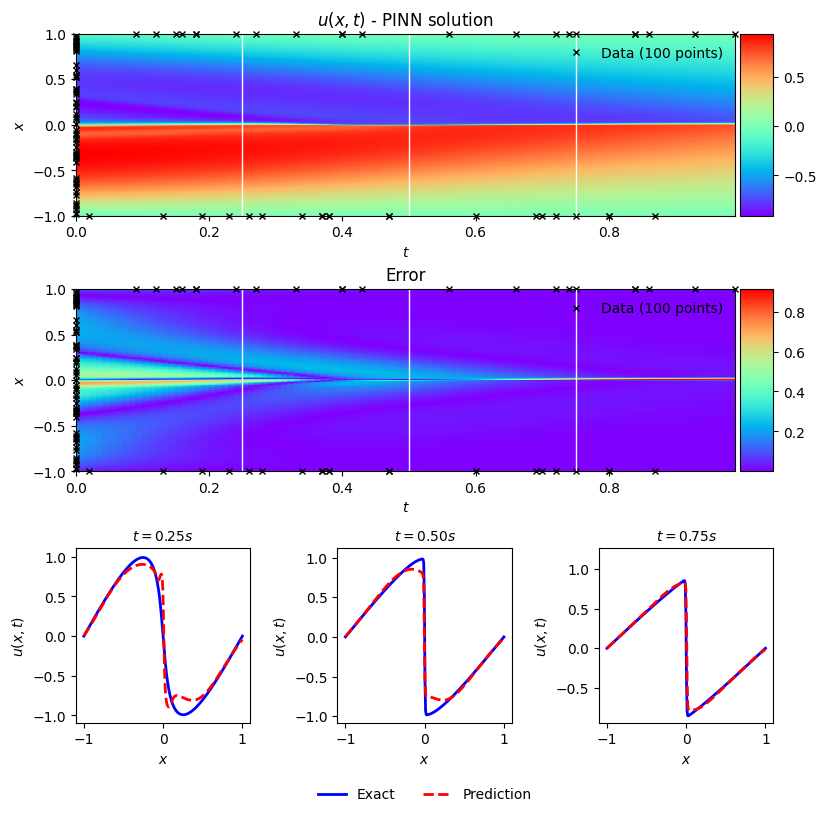

In [3]:
# Prepare the test data
Xt_u_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_true = usol.flatten('F')[:, None]

Xt_u_test = torch.from_numpy(Xt_u_test).float()
u_true = torch.from_numpy(u_true).float()

# Predict u using the trained PINN model
u_pred_test = pinn_model(Xt_u_test)

# Calculate the relative L2 error between predicted and true values
error_vector = torch.linalg.norm((u_true - u_pred_test), 2) / torch.linalg.norm(u_true, 2)
print(f"Test Error: {error_vector.item():.5f}")

# Plot the solution
solution_plot(u_pred_test.cpu().detach().numpy().reshape((256, 100), order='F'), 
                 usol, x, t, X, T, Xt_u_train,u_train)

## By adapting seq2seq learning with 2 time segment, the test error reduced from 0.29558 to 0.18779 (-36%), the plot shows a much closer match to the exact solution.

## As shown, the performance is poorer at earlier times due to the increased complexity (rapid change of its derivatives) of the function near $t=0$. I attempted to loop over the time segments twice, from $t=0$ to $t=1$ and back to $t=0$, in an effort to improve the fit. However, this approach resulted in overfitting, which I have not showed here."

In [4]:
def function(u0: str):
    """Initial condition, string --> function."""

    if u0 == 'sin(x)':
        u0 = lambda x: np.sin(x)
    elif u0 == 'sin(pix)':
        u0 = lambda x: np.sin(np.pi*x)
    elif u0 == 'sin^2(x)':
        u0 = lambda x: np.sin(x)**2
    elif u0 == 'sin(x)cos(x)':
        u0 = lambda x: np.sin(x)*np.cos(x)
    elif u0 == '0.1sin(x)':
        u0 = lambda x: 0.1*np.sin(x)
    elif u0 == '0.5sin(x)':
        u0 = lambda x: 0.5*np.sin(x)
    elif u0 == '10sin(x)':
        u0 = lambda x: 10*np.sin(x)
    elif u0 == '50sin(x)':
        u0 = lambda x: 50*np.sin(x)
    elif u0 == '1+sin(x)':
        u0 = lambda x: 1 + np.sin(x)
    elif u0 == '2+sin(x)':
        u0 = lambda x: 2 + np.sin(x)
    elif u0 == '6+sin(x)':
        u0 = lambda x: 6 + np.sin(x)
    elif u0 == '10+sin(x)':
        u0 = lambda x: 10 + np.sin(x)
    elif u0 == 'sin(2x)':
        u0 = lambda x: np.sin(2*x)
    elif u0 == 'tanh(x)':
        u0 = lambda x: np.tanh(x)
    elif u0 == '2x':
        u0 = lambda x: 2*x
    elif u0 == 'x^2':
        u0 = lambda x: x**2
    elif u0 == 'gauss':
        x0 = np.pi
        sigma = np.pi/4
        u0 = lambda x: np.exp(-np.power((x - x0)/sigma, 2.)/2.)
    return u0

def reaction(u, rho, dt):
    """ du/dt = rho*u*(1-u)
    """
    factor_1 = u * np.exp(rho * dt)
    factor_2 = (1 - u)
    u = factor_1 / (factor_2 + factor_1)
    return u

def diffusion(u, nu, dt, IKX2):
    """ du/dt = nu*d2u/dx2
    """
    factor = np.exp(nu * IKX2 * dt)
    u_hat = np.fft.fft(u)
    u_hat *= factor
    u = np.real(np.fft.ifft(u_hat))
    return u

def reaction_diffusion_discrete_solution(u0 : str, nu, rho, nx = 256, nt = 100):
    """ Computes the discrete solution of the reaction-diffusion PDE using
        pseudo-spectral operator splitting.
    Args:
        u0: initial condition
        nu: diffusion coefficient
        rho: reaction coefficient
        nx: size of x-tgrid
        nt: number of points in the t grid
    Returns:
        u: solution
    """
    L = 2*np.pi
    T = 1
    dx = L/nx
    dt = T/nt
    x = np.arange(0, L, dx) # not inclusive of the last point
    t = np.linspace(0, T, nt).reshape(-1, 1)
    X, T = np.meshgrid(x, t)
    u = np.zeros((nx, nt))
    k = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    IKX = 1j * k
    IKX2 = IKX * IKX

    # call u0 this way so array is (n, ), so each row of u should also be (n, )
    u0 = function(u0)
    u0 = u0(x)

    u[:,0] = u0
    u_ = u0
    for i in range(nt-1):
        u_ = reaction(u_, rho, dt)
        u_ = diffusion(u_, nu, dt, IKX2)
        u[:,i+1] = u_

    # u = u.T
    # u = u.flatten()
    return u



PINN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|                                                                                                                                                                                 | 0/2 [00:00<?, ?it/s]

Segment 1, Iteration 1000/5000, Loss: 0.006542193703353405
Segment 1, Iteration 2000/5000, Loss: 0.001363686053082347
Segment 1, Iteration 3000/5000, Loss: 0.007555240765213966
Segment 1, Iteration 4000/5000, Loss: 0.0008724716026335955


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1/2 [00:26<00:26, 26.34s/it]

Segment 1, Iteration 5000/5000, Loss: 0.0007668292964808643
Segment 2, Iteration 1000/5000, Loss: 0.004628750961273909
Segment 2, Iteration 2000/5000, Loss: 0.0015365988947451115
Segment 2, Iteration 3000/5000, Loss: 0.0009252825402654707
Segment 2, Iteration 4000/5000, Loss: 0.0007250391645357013


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:54<00:00, 27.29s/it]

Segment 2, Iteration 5000/5000, Loss: 0.0006067698122933507
Test Error: 0.14348


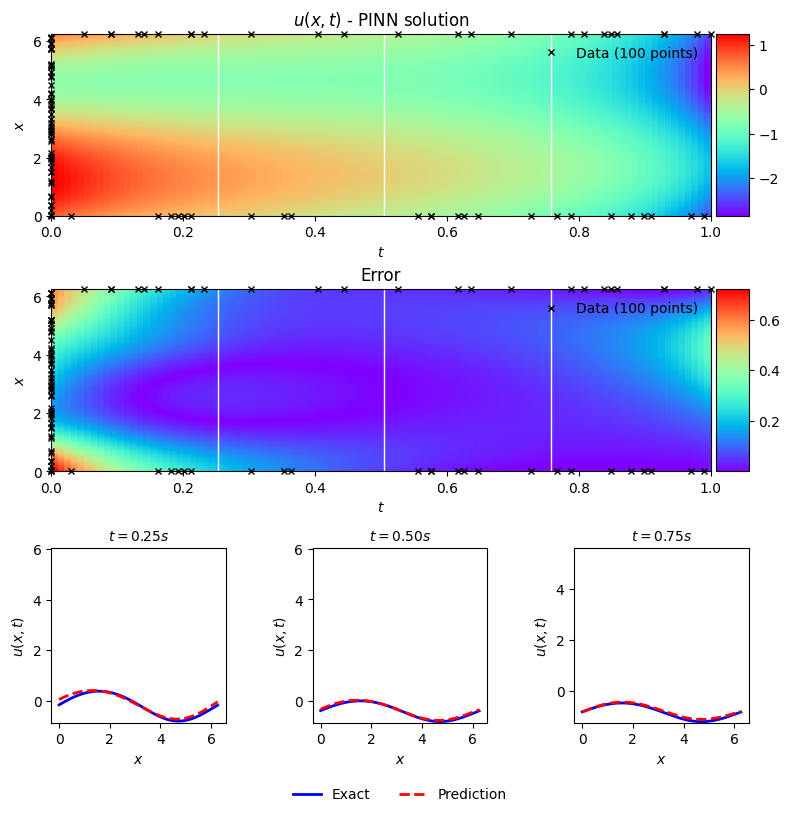

In [5]:
# Load numerical solution data from the file
L = 2*np.pi
T = 1
dx = L/256
x = np.arange(0, L, dx).reshape(-1, 1) # not inclusive of the last point
t = np.linspace(0, T, 100).reshape(-1, 1)
u0_str = 'sin(x)'
nu = 4.25
rho = 1.75

usol = reaction_diffusion_discrete_solution(u0_str, nu, rho, 256, 100)                         # solution of 256x100 grid points
X, T = np.meshgrid(x,t)  
#plot_exact_solution(usol, X, T)

# TODO: Instantiate the PINN model
pinn_model2 = PINN(
    input_dim=2,  # 2D input (x, t)
    hidden_dim=32,  # Hidden layer size
    output_dim=1,  # Output (u)
    num_layers=3  # Number of hidden layers
)

# Display the neural network architecture
print(pinn_model2)


# Define the domain bounds
lower_bound = np.array([X.min(), T.min()])  # [x_min, t_min] = [-1, 0]
upper_bound = np.array([X.max(), T.max()])  # [x_max, t_max] = [1, 0.99]

# Generate training data (boundary and initial conditions)
N_u = 100  # Number of boundary condition points
N_f = 10_000  # Number of colocation points

# seq2seq setup
num_time_segments = 2 # Number of segments to divide the time into
timesteps = np.linspace(0, 1, num_time_segments + 1)  # Time intervals
# we divide the data into several segment meaning we have fewer training data for each segment, and poor training performance (mostly in the first segment)
# so we increase the number of iterations for better result
max_iterations = 5000

# Initial condition: -1 <= x <= 1, t = 0
initial_condition_xt = np.hstack((X[0, :][:, None], T[0, :][:, None]))
initial_condition_u = usol[:, 0][:, None]

# TODO: Boundary condition: x = -1, 0 <= t <= 1
boundary_left_xt = np.hstack((X[:, 0][:, None], T[:, 0][:, None]))
boundary_left_u = usol[0, :][:, None]

# TODO: Boundary condition: x = 1, 0 <= t <= 1
boundary_right_xt =  np.hstack((X[:, -1][:, None], T[:, -1][:, None]))
boundary_right_u = usol[-1, :][:, None]

# Combine boundary and initial condition points
all_xt_u_train = np.vstack([initial_condition_xt, boundary_left_xt, boundary_right_xt])
all_u_train = np.vstack([initial_condition_u, boundary_left_u, boundary_right_u])


selected_indices = np.random.randint(0, all_u_train.shape[0], N_u)
Xt_u_train = all_xt_u_train[selected_indices, :]
u_train = all_u_train[selected_indices, :]

idx = np.where(Xt_u_train[:,1] != 0)[0]
boundary_Xt_train = Xt_u_train[idx, :]
boundary_u_train = u_train[idx, :]

idx = np.where(Xt_u_train[:,1] == 0)[0]
initial_Xt_train = Xt_u_train[idx, :]
initial_u_train = u_train[idx, :]

# Set up the optimizer
optimizer = torch.optim.Adam(pinn_model2.parameters(), lr=0.001)


# Training loop over time segments
for segment in tqdm(range(num_time_segments)):
    start_time = timesteps[segment]
    end_time = timesteps[segment + 1]
    lower_bound[1] = start_time
    upper_bound[1] = end_time
    if segment!=0:
        with torch.no_grad():
            initial_Xt_train[:,1] =  start_time
            _initial_condition_xt = torch.from_numpy(initial_Xt_train).float()
            initial_u_train = pinn_model2(_initial_condition_xt)
    # Extract training data for the current time segment
    t_u = boundary_Xt_train[:,1]
    boundary_idx = np.where((t_u >= start_time) & (t_u < end_time))[0]  # Indices for u data

    # Combine boundary and initial condition points
    seg_xt_u_train = np.vstack([initial_Xt_train, boundary_Xt_train[boundary_idx]])
    seg_u_train = np.vstack([initial_u_train, boundary_u_train[boundary_idx]])

    
    # Initialize Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=2)  # 2 dimensions: x and t
    # Generate N_f samples in the unit square [0, 1] and scale to the desired domain
    samples = sampler.random(n=int(N_f/num_time_segments))
    # TODO: Generate colocation points using Latin Hypercube Sampling
    Xt_f_train = qmc.scale(samples, lower_bound, upper_bound)
    Xt_f_train = np.vstack([Xt_f_train, seg_xt_u_train])  # Append boundary points to colocation points
    

    # Create tensors for current segment data
    current_xt_u_train = torch.from_numpy(seg_xt_u_train).float()
    current_u_train = torch.from_numpy(seg_u_train).float()
    current_f_xt = torch.from_numpy(Xt_f_train).float()
    f_hat = torch.zeros(current_f_xt.shape[0], 1)

    # Inner loop for iterations
    for iteration in range(max_iterations):
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass for the current segment
        u_pred_train = pinn_model2(current_xt_u_train)

        # Compute the loss for boundary conditions
        loss_u = F.mse_loss(u_pred_train, current_u_train)

        # Compute the PDE residual loss using automatic differentiation
        current_f_xt.requires_grad = True
        u_pred_collocation = pinn_model2(current_f_xt)

        # Compute first and second derivatives w.r.t. x and t
        u_grad = torch.autograd.grad(u_pred_collocation, current_f_xt,
                                     grad_outputs=torch.ones_like(u_pred_collocation),
                                     create_graph=True, allow_unused=True)[0]

        u_x = u_grad[:, [0]]
        u_t = u_grad[:, [1]]

        u_xx = torch.autograd.grad(u_x, current_f_xt,
                                   grad_outputs=torch.ones_like(u_x),
                                   create_graph=True, allow_unused=True)[0]

        u_xx = u_xx[:, [0]]  # Assuming you want to extract the first column

        # Compute the PDE residual
        f_residual = u_t - nu * u_xx - rho * u_pred_collocation * (1- u_pred_collocation)
        loss_f = F.mse_loss(f_residual, f_hat)

        # Combine losses and backpropagate
        total_loss = loss_u + loss_f
        total_loss.backward()

        # Print the loss every 100 iterations
        if (iteration + 1) % 1000 == 0:
            print(f"Segment {segment + 1}, Iteration {iteration + 1}/{max_iterations}, Loss: {total_loss.item()}")

        # Perform optimization step
        optimizer.step()
    
# Prepare the test data
Xt_u_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_true = usol.flatten('F')[:, None]

Xt_u_test = torch.from_numpy(Xt_u_test).float()
u_true = torch.from_numpy(u_true).float()

# Predict u using the trained PINN model
u_pred_test = pinn_model2(Xt_u_test)

# Calculate the relative L2 error between predicted and true values
error_vector = torch.linalg.norm((u_true - u_pred_test), 2) / torch.linalg.norm(u_true, 2)
print(f"Test Error: {error_vector.item():.5f}")

# Plot the solution
solution_plot(u_pred_test.cpu().detach().numpy().reshape((256, 100), order='F'), 
                 usol, x, t, X, T, Xt_u_train,u_train)

## By adapting seq2seq learning with 2 time segment, the test error reduced from 0.24739 to 0.14348 (-40%), the plot shows a much closer match to the exact solution.
## Dividing the training data into two segments reduced the amount of data associated with the initial condition ($t=0$), leading to a worse fit near $t=0$. However, continuously updating the initial condition between segments $(t=t_0>0)$ improved the training performance near $t=1$.